# **응급상황 자동 인식 및 응급실 연계 서비스**
# 단계2 : 파인튜닝

### (1) 미션1
사전 학습된 한국어 BERT 모델을 다운받아, 파인튜닝을 시도. 이를 위해 먼저 적절한 데이터를 수집

* 학습 데이터 준비
    * 등급별 50개씩 샘플 데이터를 제공합니다.
    * **응급상황 등급(1~5) 별 최소 100건씩** 데이터를 추가로 수집(제작)하세요.
        * 중증도 카테고리 파일에 있는 키워드 참조
        * 제작시 GPT를 적극 활용해 봅시다.
    * 총 데이터 크기 : 600건
        * 제공데이터 100건(20건씩 5개 등급)
        * 추가 제작 500건(100건씩 5개 등급)

|text|label|
|----|----|
|GPT모델의 출력 형태. 응급상황 내용 | 응급등급(1~5)|



In [2]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/project6/2/'
!pip install -r /content/drive/MyDrive/project6/2/requirements.txt

#필요한 라이브러리 설치 및 불러우기
import os
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import openai
from openai import OpenAI
import json

def load_file(filepath):
    with open(filepath, 'r') as file:
        return file.readline().strip()

# API 키 로드 및 환경변수 설정
openai.api_key = load_file(path + 'api_key.txt')
os.environ['OPENAI_API_KEY'] = openai.api_key

# print(os.environ['OPENAI_API_KEY'])

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
df = pd.DataFrame(columns=['text', 'label'])

In [3]:
def ask_chatgpt2(sys_role, question):

    # client = OpenAI(api_key = openai.api_key) # 시스템 환경변수로 넣어놨음
    client = OpenAI()

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": sys_role},
            {"role": "user", "content": question},
        ]
    )

    return response.choices[0].message.content

In [88]:
sys_role = '당신은 119 응급차에서 근무하는 당직 의사, 간호사 입니다. 수많은 응급 상황 신고에 대한 정보를 가지고 있으며, 해당 정보를 KTAS 등급에 따라 분류할 수 있습니다. 이에 대한 정보를 제공할 수 있습니다.'

question = '''KTAS 5단계에 따른 응급 상황 내용과 응급 등급 데이터 10개 만들어줘. 단 응답은 다음의 형식을 꼭 지켜줘 : [{"text": "응급 상황 내용", "label": 5}].
KTAS 5단계 상황은 이런 상황들이야.	긴급하지만 응급은 아닌 상태, 만성적인 문제로 인한 것이거나, 악화의 가능성이 낮은 상태.감기, 장염, 설사, 열상(상처)정도의 상태. 최대한 다양하고 겹치지 않은 응급 상태 데이터로 만들어줘. 증상은 이해하기 쉬운 단어로 만들어줘.'''
response = ask_chatgpt2(sys_role, question)



In [89]:
print(response)

[
    {"text": "목이 아프고 콧물이 나는 감기 증상이 있습니다.", "label": 5},
    {"text": "소화불량으로 인한 복부 통증을 호소하는 환자가 있습니다.", "label": 5},
    {"text": "피부에 따가운 각질이 생겨 피부 미백 제품을 사용한 경우 색소침착 증상을 호소합니다.", "label": 5},
    {"text": "가래가 나오며 기침을 반복하는 환자가 있습니다.", "label": 5},
    {"text": "식사 이후 속 쓰림과 구토 증상이 나타난 환자가 있습니다.", "label": 5},
    {"text": "피부 조직이 약간 다쳐 화상 증상을 보이는 환자가 있습니다.", "label": 5},
    {"text": "배변 시 설사와 복통이 동반되는 환자가 있습니다.", "label": 5},
    {"text": "식사 중 생선 뼈를 삼켰는데 특별한 증상이 없는 환자가 있습니다.", "label": 5},
    {"text": "턱이 아프고 이빨이 뾰족하게 자란 환자가 있습니다.", "label": 5},
    {"text": "여드름이 생겨 피부에 뾰루지가 생기는 증상을 호소하는 환자가 있습니다.", "label": 5}
]


In [36]:
import pandas as pd

# JSON 데이터
data = [{"text": "심한 호흡곤란과 함께 가슴 통증이 지속되고 있는 환자", "label": 1},
{"text": "긴급 수술이 필요한 큰 출혈으로 혈액이 과도하게 유출되고 있는 환자", "label": 1},
{"text": "급성 심근경색으로 인한 심지혈관 폐색으로 심부전의 증상을 보이고 있는 환자", "label": 1},
{"text": "중증적인 두경부 손상으로 혈액이 많이 흐르고 출혈이 멈추지 않는 환자", "label": 1},
{"text": "신체의 일부분이 갑작스럽게 마비되어 움직일 수 없는 환자", "label": 1},
{"text": "급성 뇌출혈로 의식이 뚝뚝 떠는 환자", "label": 1},
{"text": "중증 중독으로 혼수 상태에 빠진 환자", "label": 1},
{"text": "심장마비로 인한 협심증으로 의식을 회복하지 못한 환자", "label": 1},
{"text": "크게 다친 상태에서 의식을 잃은 환자", "label": 1},
{"text": "화재로부터 발생한 중증화상을 입은 환자", "label": 1},
{"text": "급성 심근경색을 의심할 만한 가슴 통증을 호소하는 환자", "label": 1},
{"text": "급성 중독으로 혼수상태에 빠진 환자", "label": 1},
{"text": "지속적인 중증적 호흡곤란으로 산소 요구량이 증가된 환자", "label": 1},
{"text": "심한 지속적인 정신병적 증세를 보이는 환자", "label": 1},
{"text": "중증의 타박상으로 충격 상태에 있는 환자", "label": 1},
{"text": "급성 심부전으로 호흡곤란과 함께 의식상태가 뚝뚝 떨어진 환자", "label": 1},
{"text": "음주나 약물 과다 복용으로 혼수상태에 빠진 환자", "label": 1},
{"text": "가슴 통증으로 의식이 불명확한 환자", "label": 1},
{"text": "급성 심부전으로 호흡도 어렵고 의식도 낮은 환자", "label": 1},
{"text": "정신적인 문제로 인한 자해 시도를 하는 환자", "label": 1},
{"text": "급성 고혈압으로 인해 의식을 잃어버린 환자", "label": 1},
{"text": "가슴 통증에 호흡곤란이 동반되는 환자", "label": 1},
{"text": "신경계 질환으로 의식이 뚝뚝 떨어지는 환자", "label": 1},
{"text": "크게 다친 부위가 출혈하여 혈액이 흐르는 환자", "label": 1},
{"text": "급성 뇌출혈로 인해 의식을 잃어버린 환자", "label": 1},
{"text": "긴급 중독 증상으로 혼수상태에 빠진 환자", "label": 1},
{"text": "중증한 두경부 손상 후 출혈이 멈추지 않는 환자", "label": 1},
{"text": "긴급 수술이 필요한 큰 출혈로 혈액이 과도하게 소실되고 있는 환자", "label": 1},
{"text": "급성 심부전으로 호흡이 곤란한 상태에 있는 환자", "label": 1},
{"text": "대출혈로 인한 출혈이 멈추지 않는 환자", "label": 1},
{"text": "긴급 수술이 필요한 크게 다친 상태의 환자", "label": 1},
{"text": "급성 지각 장애로 현실과 인지기능이 혼동되는 환자", "label": 1},
{"text": "중증 정신 마비로 혼란 상태에 빠진 환자", "label": 1},
{"text": "급성 중독으로 인해 혼수에 빠진 환자", "label": 1},
{"text": "심장마비로 인한 심부전 증상을 보이는 환자", "label": 1},
{"text": "화재로부터 온 중증 화상 상태인 환자", "label": 1},
{"text": "긴급 중독으로 인해 혼수 상태인 환자", "label": 1},
{"text": "긴급 조기 출혈로 인한 응급 상황에 처한 환자", "label": 1},
{"text": "긴급 수술이 필요한 중증 중독 환자", "label": 1},
{"text": "긴급 수술이 필요한 큰 출혈로 혈액이 크게 소실된 환자", "label": 1},
{"text": "긴급 중독으로 혼수 상태에 빠진 환자", "label": 1},
{"text": "긴급 중독으로 인한 의식불명 환자", "label": 1},
{"text": "긴급 심부전으로 호흡곤란을 호소하는 환자", "label": 1},
{"text": "위급한 호흡곤란으로 심장 마비에 이르는 환자", "label": 1},
{"text": "긴급 수술이 필요한 중증 상태인 환자", "label": 1},
{"text": "긴급 중독으로 인한 의식상태 이상 환자", "label": 1},
{"text": "긴급 중독으로 인한 자기폭행을 시도하고 있는 환자", "label": 1},
{"text": "긴급 수술이 필요한 큰 출혈로 혈액이 과도하게 유출되는 환자", "label": 1},
{"text": "긴급 수술이 필요한 크게 다친 상태의 환자", "label": 1},
{"text": "긴급 중독으로 인한 혼수 상태의 환자", "label": 1},
{"text": "길이 자해를 시도하는 중요한 흉부 출혈 환자", "label": 1},
{"text": "긴급 중독으로 인한 혼수 상태의 의식 명확하지 못한 환자", "label": 1},
{"text": "긴급 중독으로 인한 혼수 상태의 정신 생리 이상 환자", "label": 1},
{"text": "긴급 중독으로 인한 약물 과다 복용으로 혼령 상태의 환자", "label": 1},
{"text": "긴급 중독으로 인한 혼신에 난 급성 중독 증상이 있는 환자", "label": 1},
{"text": "위급한 호흡곤란 증세와 심장 마비의 의심이 있는 환자", "label": 1},
{"text": "긴급 수술이 필요한 중증 중독 상태인 환자", "label": 1},
{"text": "신체의 긴급적인 응급처치를 요하는 크게 다친 환자", "label": 1},
{"text": "심장마비로 인한 응급 상황", "label": 1},
{"text": "심폐소생술이 필요한 상태", "label": 1},
{"text": "급성 뇌졸중으로 인한 신속한 의료 처리가 필요한 상황", "label": 1},
{"text": "심근경색으로 생명이 위험한 상태", "label": 1},
{"text": "급성 호흡곤란으로 인한 응급 처치가 필요한 상황", "label": 1},
{"text": "사지 절단 상태로 출혈이 심각한 상황", "label": 1},
{"text": "중증 외상으로 신속한 응급 치료가 필요한 상태", "label": 1},
{"text": "알레르기 쇼크로 인한 긴급 처치가 필요한 상황", "label": 1},
{"text": "음식물에 의한 기도폐쇄로 인한 급성 호흡곤란", "label": 1},
{"text": "중증 천식 발작으로 생명이 위험한 상태", "label": 1},
{"text": "사지 골절로 인한 과도한 통증과 출혈이 일어난 상황", "label": 1},
{"text": "급성 심부전으로 생명이 위험할 수 있는 상태", "label": 1},
{"text": "알콜 중독으로 인한 심신 이상 상태", "label": 1},
{"text": "중증 소화성 궤양으로 인한 출혈과 극심한 복통", "label": 1},
{"text": "두부 외상으로 인한 무의식 상태", "label": 1},
{"text": "중독으로 인한 혼수 상태", "label": 1},
{"text": "급성 신부전으로 응급 투석이 필요한 상황", "label": 1},
{"text": "심혈관계 질환으로 인한 급성 심부전 발작", "label": 1},
{"text": "독극물 물림으로 인한 사지 부종과 발적이 심각한 상황", "label": 1},
{"text": "급성 뇌출혈로 인한 빠른 신경외과 수술이 필요한 상태", "label": 1},
{"text": "중증 피부 홍반병으로 인한 알레르기 반응", "label": 1},
{"text": "급성 뇌염으로 인한 의식 변화와 경련 발작", "label": 1},
{"text": "급성 심방세동으로 인한 심혈관 사고", "label": 1},
{"text": "중증 폐렴으로 인한 호흡 어려움과 발열", "label": 1},
{"text": "중독성 간염으로 응급 간 이식이 필요한 상황", "label": 1},
{"text": "급성 심근염으로 인한 협심증 발작", "label": 1},
{"text": "시신경막염으로 인한 신경계 이상 증세", "label": 1},
{"text": "긴장성 두통으로 인한 혼란과 의식 손상", "label": 1},
{"text": "급성 질환으로 인한 혼수 상태", "label": 1},
{"text": "심장마비의 위험성이 있는 상태", "label": 1},
{"text": "중증 당뇨병 케토아산토남으로 인한 혼동 상태", "label": 1},
{"text": "급성 심근경색으로 인한 정맥 혈전증", "label": 1},
{"text": "급성 신기능 저하로 인한 요화학적 이상", "label": 1},
{"text": "급성 간염으로 인해 혈액 독성 상승", "label": 1},
{"text": "급성 대동맥 박리로 인한 생명 위협적인 상세", "label": 1},
{"text": "급성 폐색종으로 인한 호흡 곤란", "label": 1},
{"text": "급성 장골치염으로 인한 충혈과 통증", "label": 1},
{"text": "미용 판독이 필요한 심혈관계 질환으로 인한 정신 변화", "label": 1},
{"text": "급성 신위경화로 인한 알콜 이상 환자", "label": 1},
{"text": "심장마비 환자", "label": 1},
{"text": "급성 호흡곤란", "label": 1},
{"text": "중증의 두통과 구토", "label": 1}]

# 데이터프레임으로 변환
label1 = pd.DataFrame(data)

# 데이터프레임 출력
print(label1)


                                         text  label
0               심한 호흡곤란과 함께 가슴 통증이 지속되고 있는 환자      1
1       긴급 수술이 필요한 큰 출혈으로 혈액이 과도하게 유출되고 있는 환자      1
2   급성 심근경색으로 인한 심지혈관 폐색으로 심부전의 증상을 보이고 있는 환자      1
3      중증적인 두경부 손상으로 혈액이 많이 흐르고 출혈이 멈추지 않는 환자      1
4             신체의 일부분이 갑작스럽게 마비되어 움직일 수 없는 환자      1
..                                        ...    ...
95              미용 판독이 필요한 심혈관계 질환으로 인한 정신 변화      1
96                       급성 신위경화로 인한 알콜 이상 환자      1
97                                    심장마비 환자      1
98                                    급성 호흡곤란      1
99                                 중증의 두통과 구토      1

[100 rows x 2 columns]


In [49]:
import pandas as pd

# JSON 데이터
data = [{"text": "가슴 통증으로 호흡이 어려워지고 응급실으로 급히 이송되어야 합니다.", "label": 2},
{"text": "폐렴으로 인해 호흡이 곤란하며 응급적인 처치가 필요합니다.", "label": 2},
{"text": "응급실에서 혈액 돌연변이로 인한 출혈로 인해 급한 수술이 필요합니다.", "label": 2},
{"text": "급성 심근경색 증상으로 주변부에 통증이 생기고 응급적인 심장 마취가 필요합니다.", "label": 2},
{"text": "두려움과 체한 호흡, 식은땀이 나며 응급상황으로 판단됩니다.", "label": 2},
{"text": "흉부 통증과 호흡곤란이 동반될 때 심근경색이 의심되어 응급적으로 치료가 필요합니다.", "label": 2},
{"text": "뇌졸중으로 인해 언어 장애와 왼쪽 팔의 마비 증상이 나타나 응급실에서 적절한 처치가 필요합니다.", "label": 2},
{"text": "급성 심근경색이 의심되어 흉통과 호흡곤란과 함께 증상이 나타나며 응급 치료가 필요합니다.", "label": 2},
{"text": "급성 뇌출혈로 인해 의식 잃고 양쪽 팔다리 마비 증상이 나타나 급히 수술이 필요합니다.", "label": 2},
{"text": "폴리오로 인한 호흡곤란 증상이 나타나 급하게 응급실로 이송되어야 합니다.", "label": 2},
{"text": "사람 신체에 뻣뻣한 통증과 혈액 순환이 원활하지 않으면 응급 치료가 필요합니다.", "label": 2},
{"text": "중증 결막염으로 눈을 깜박대거나 눈을 가리는 증세가 나타나면 응급적인 치료가 필요합니다.", "label": 2},
{"text": "단순한 이질과 호흡이 곤란해지며 응급적인 처치가 필요합니다.", "label": 2},
{"text": "고열과 두통으로 환자가 의식을 잃을 위험이 있으므로 응급실로 이송되어야 합니다.", "label": 2},
{"text": "급성 뇌경색으로 인해 말더듬과 팔 다리 마비 증상이 나타나 응급 수술이 필요합니다.", "label": 2},
{"text": "뇌출혈로 인해 혼수 상태에 빠지고 호흡이 불규칙해지면 즉각적인 치료가 필요합니다.", "label": 2},
{"text": "급성 심근경색으로 모독통과 함께 호흡곤란이면 흉통으로 응급실로 이송되어야 합니다.", "label": 2},
{"text": "고혈압으로 인해 두통과 혼돈이 증상이 나타나 급히 응급실로 이송되어야 합니다.", "label": 2},
{"text": "결막염으로 눈이 붉고 가렵다면 응급적인 치료가 필요합니다.", "label": 2},
{"text": "급성 심근경색으로 심장부위가 아프고 호흡이 어려워지면 수술로 급히 처치되어야 합니다.", "label": 2},
{"text": "급성 뇌출혈로 인해 의식 잃고 몸이 붓고 호흡이 곤란해지면 급한 처리가 필요합니다.", "label": 2},
{"text": "극도로 저체온이 되어 먹은 파묻혔으면 응급적인 처치가 필요합니다.", "label": 2},
{"text": "급성 심근경색으로 가슴이 아파서 호흡이 어려워지면 직접 치료가 필요합니다.", "label": 2},
{"text": "아토피성 기관지염으로 호흡곤란과 하품이 나타나면 급히 응급실로 이송되어야 합니다.", "label": 2},
{"text": "급성 뇌출혈로 인해 혼란과 언어장애 증상이 나타나면 즉시 수술이 필요합니다.", "label": 2},
{"text": "항열제 과다 복용으로 호흡이 어려워지고 두통이 심하다면 응급 치료가 필요합니다.", "label": 2},
{"text": "급성 심근경색으로 인해 가슴이 메어지고 호흡곤란이 생기며 응급 수술이 필요합니다.", "label": 2},
{"text": "급성 뇌경색으로 인해 말더듬과 팔다리 마비 증상이 나타나 응급 수술이 필요합니다.", "label": 2},
{"text": "뇌출혈로 인해 의식이 소실되고 혈압이 급속히 하락하면 즉각적인 치료가 필요합니다.", "label": 2},
{"text": "급성 심근경색으로 가슴이 아파서 호흡이 어려워지면 직접 치료가 필요합니다.", "label": 2},
{"text": "간질로 인한 갑작스러운 저신음으로 경련과 쇽이 나타나면 응급적인 처치가 필요합니다.", "label": 2},
{"text": "급성 심근경색으로 인해 가슴이 메어지고 호흡곤란이 생기며 응급 수술이 필요합니다.", "label": 2},
{"text": "급성 뇌출혈로 인해 의식을 잃고 팔다리 마비 증상이 나타나면 즉각적인 수술이 필요합니다.", "label": 2},
{"text": "폭풍우로 인한 교통사고로 인해 부상을 입고 출혈로 인한 급히 수술이 필요합니다.", "label": 2},
{"text": "급성 뇌출혈로 인해 의식을 잃고 양쪽 팔다리 마비증상이 나타나 급한 수술 필요합니다.", "label": 2},
{"text": "삼중수막염으로 인해 두통과 망기가 나타나는 증상이 나타나면 응급적인 처치가 필요합니다.", "label": 2},
{"text": "급성 심근경색으로 호흡이 곤란해지고 가슴이 아플 때 응급실로 이송되어야 합니다.", "label": 2},
{"text": "폐색소폐증으로 호흡이 어려워지고 기침과 가래가 나타나면 응급 치료가 필요합니다.", "label": 2},
{"text": "급성 뇌출혈로 인해 의식 잃고 몸이 붓고 호흡이 곤란해지면 급한 처리가 필요합니다.", "label": 2},
{"text": "급성 심근경색으로 가슴이 아파서 호흡이 어려워지면 직접 치료가 필요합니다.", "label": 2},
{"text": "경련을 일으키는 질환으로 인해 의식이 불분명하고 과호흡이 발생하면 응급 수술이 필요합니다.", "label": 2},
{"text": "급성 심근경색으로 심장주위가 아파고 호흡이 어려울 때 즉각 처치가 필요합니다.", "label": 2},
{"text": "고혈압으로 인해 양무릎과 양어깨에 통증과 혼란이 생기면 응급 수술이 필요합니다.", "label": 2},
{"text": "급성 뇌출혈로 인해 의식 소실되고 몸이 마비되며 급히 치료가 필요합니다.", "label": 2},
{"text": "뇌출혈로 인해 혼란과 언어 장애가 나타나면 즉시 수술이 필요합니다.", "label": 2},
{"text": "급성 심근경색으로 심장부위가 아프고 호흡이 어려워지면 수술로 급히 처치되어야 합니다.", "label": 2},
{"text": "급성 뇌출혈로 인해 의식을 소실하고 팔다리 마비 증상이 나타나면 급해서 수술이 필요합니다.", "label": 2},
{"text": "고열로 의식이 혼미해지고 손발이 마비되면 응급처치가 필요합니다.", "label": 2},
{"text": "심장의 급성 경색으로 흉통과 호흡곤란이 생기면 즉각적인 처치가 필요합니다.", "label": 2},
{"text": "급성 뇌경색으로 말더듬과 팔다리 마비증상이 나타나면 즉각적인 치료가 필요합니다.", "label": 2},
{"text": "뇌출혈로 인해 혼란이 생기고 잇몸이 없으면 즉각적으로 수술이 필요합니다.", "label": 2},
{"text": "급성 심근경색으로 말뿐과 호흡이 어려워지면 즉각적 치료가 필요합니다.", "label": 2},
{"text": "소아마비로 인해 팔다리마비와 복부통증을 호소할 때 응급 치료가 필요합니다.", "label": 2},
{"text": "급성 심근경색으로 소름이 돋고 호흡이 어려워지면 치료가 필요합니다.", "label": 2},
{"text": "뇌출혈로 인해 의식을 소실하고 팔다리 마비 증상이 나타나면 즉각적인 치료가 필요합니다.", "label": 2},
{"text": "고열로 인해 혼돈이 오고 손주통증을 호소할 때 응급 치료가 필요합니다.", "label": 2},
{"text": "심장의 급성 경색으로 인해 손뿐과 호흡이 어려워지면 치료가 필요합니다.", "label": 2},
{"text": "급성 뇌출혈로 인해 머리가 아프고 언어장애증상이 나타나 즉각적 치료가 필요합니다.", "label": 2},
{"text": "뇌출혈로 인해 혼동과 언어장애가 나타나는 증상이 나타나면 즉각적 치료가 필요합니다.", "label": 2},
{"text": "가슴 통증 및 압박감이 갑자기 시작되어 호흡 곤란을 호소하는 환자", "label": 2},
{"text": "갑작스럽고 심한 두통과 의식 변화가 나타나는 환자", "label": 2},
{"text": "심한 흉통으로 호흡 곤란을 겪는 환자", "label": 2},
{"text": "응급실에서 긴급한 혈압 강하제 요구하는 환자", "label": 2},
{"text": "초저온 환자가 혈압 저하와 호흡 어려움을 겪는 중", "label": 2},
{"text": "바닥에 쓰러진 환자가 심장마비를 의심받아 구급차를 요청함", "label": 2},
{"text": "흐릿한 시각과 균형 장애로 특정 부위에 마비 증상이 나타난 환자", "label": 2},
{"text": "중증 폐렴으로 호흡 속도가 빨라지고 가슴부터 코카노드 사용함", "label": 2},
{"text": "간헐적으로 심장마비와 호흡 중단 증상이 발생하는 환자", "label": 2},
{"text": "혈압과 맥박이 급격히 낮아지고 의식 변화를 보이는 환자", "label": 2},
{"text": "성인에서 고열과 정신 변화를 보이는 중", "label": 2},
{"text": "통증과 호흡 곤란을 호소하며 발적 발견한 환자", "label": 2},
{"text": "가슴 통증과 호흡곤란을 호소하는 갑작스럽게 발생한 환자", "label": 2},
{"text": "의식 잃은 환자가 흡입음 하는 것을 발견한 환자", "label": 2},
{"text": "의식 변화가 나타나고 두통 및 언어 장애가 있는 환자", "label": 2},
{"text": "여성이 가슴통증 및 호흡곤란으로 긴급진료를 요청함", "label": 2},
{"text": "대량응고증이 의심되어 호흡곤란 및 가슴통증 증상이 나타난 환자", "label": 2},
{"text": "최근 심부전으로 치료받은 환자가 호흡 곤란과 가슴통증을 호소함", "label": 2},
{"text": "어지러움, 순환기 증상, 및 머리 인후로 과거상황보다 열악해진 환자", "label": 2},
{"text": "가뭄으로 탈수증상과 열중이 발생한 어린 환자", "label": 2},
{"text": "소화기 증상과 혈압저하로 인한 쓰러진 환자", "label": 2},
{"text": "심메스꺼움을 호소하며 혈압 강하제 요구하는 환자", "label": 2},
{"text": "의식 잃은 환자가 보호자에게 과거병력을 호소함", "label": 2},
{"text": "허리 아래 마비를 보일 때 무릎 골절이 의심되는 환자", "label": 2},
{"text": "중첩통증과 동반되는 구토증세를 호소하는 환자", "label": 2},
{"text": "성인에서 열이 나고 의식 잃은 것을 주장하는 환자", "label": 2},
{"text": "식사 향후 바로, 흉부 통증과 호흡곤란으로 쓰러진 환자", "label": 2},
{"text": "흉부 폐쇄증으로 호흡이 곤란해질 때 호흡곤란이 더 복면된 상태", "label": 2},
{"text": "음성적인 수익형 장애가 있고 추잘 같은 면역정유질 하여 응급으로 구급차를 요청하는 환자", "label": 2},
{"text": "중요한 흉통 및 호흡 곤란 증상이 존재하는 환자", "label": 2},
{"text": "달리기 후에 무의식상태로 땅바닥에 쓰러진 환자", "label": 2},
{"text": "가슴 통증과 호흡 곤란을 동반한 환자", "label": 2},
{"text": "급격한 두통과 언어 장애가 나타난 환자", "label": 2},
{"text": "심한 혈액 응고로 인한 발한 증상을 보이는 환자", "label": 2},
{"text": "방사성 물질에 노출된 후 구토 및 구토로 인한 고열을 나타내는 환자", "label": 2},
{"text": "심각한 체중 감량과 식욕 부진이 오래 지속되는 환자", "label": 2},
{"text": "급격한 전신 부좌와 고열을 동반한 환자", "label": 2},
{"text": "응급실 도착 직전 의식 잃고 경련을 일으키는 환자", "label": 2},
{"text": "흉통과 호흡 곤란으로 심각한 심혈관 질환 가능성 있는 환자", "label": 2},
{"text": "급격한 의식 장애와 언어 이해 불가능한 환자", "label": 2},
{"text": "공격적인 행동과 환각을 보이는 환자", "label": 2}]

# 데이터프레임으로 변환
label2 = pd.DataFrame(data)

# 데이터프레임 출력
print(label2)

                                            text  label
0          가슴 통증으로 호흡이 어려워지고 응급실으로 급히 이송되어야 합니다.      2
1               폐렴으로 인해 호흡이 곤란하며 응급적인 처치가 필요합니다.      2
2         응급실에서 혈액 돌연변이로 인한 출혈로 인해 급한 수술이 필요합니다.      2
3   급성 심근경색 증상으로 주변부에 통증이 생기고 응급적인 심장 마취가 필요합니다.      2
4              두려움과 체한 호흡, 식은땀이 나며 응급상황으로 판단됩니다.      2
..                                           ...    ...
95                         급격한 전신 부좌와 고열을 동반한 환자      2
96                   응급실 도착 직전 의식 잃고 경련을 일으키는 환자      2
97              흉통과 호흡 곤란으로 심각한 심혈관 질환 가능성 있는 환자      2
98                      급격한 의식 장애와 언어 이해 불가능한 환자      2
99                           공격적인 행동과 환각을 보이는 환자      2

[100 rows x 2 columns]


In [64]:
import pandas as pd

# JSON 데이터
data = [{"text": "호흡이 어렵고 가슴이 답답한 상태", "label": 3},
{"text": "심장마비 가능성이 있는 상태", "label": 3},
{"text": "심한 혈압 상승으로 인한 두통과 혼돈", "label": 3},
{"text": "급성 위장 통증과 구토가 동반된 상태", "label": 3},
{"text": "뇌출혈 가능성이 있는 심한 두통", "label": 3},
{"text": "심해진 흉통과 숨쉬기가 곤란한 상태", "label": 3},
{"text": "심한 고통을 호소하는 환자", "label": 3},
{"text": "숨쉬기가 어려워서 몸이 부촉한 상태", "label": 3},
{"text": "혈압 급상승으로 혼란과 어지러움", "label": 3},
{"text": "등산 중 심한 복통과 혈뇌장애 가능성", "label": 3},
{"text": "심장 마비가 의심되는 흉통", "label": 3},
{"text": "흉통과 고통으로 인한 초조한 상태", "label": 3},
{"text": "급성 심근경색 가능성을 고려해야 하는 상태", "label": 3},
{"text": "심장마비 및 호흡기 탈수능성이 있는 상태", "label": 3},
{"text": "뇌출혈 가능성으로 심한 두통 호소", "label": 3},
{"text": "급성 복부 통증과 혈류장애 의심", "label": 3},
{"text": "저혈압으로 혼란 및 혈뇌장애 가능성", "label": 3},
{"text": "자살 시도 후 혈액 손실과 혼미 상태", "label": 3},
{"text": "심장 은폐하여 호흡 곤란을 호소", "label": 3},
{"text": "심해진 가슴 통증과 혼란", "label": 3},
{"text": "급성 뇌파 손상과 혼란 상태", "label": 3},
{"text": "고열을 동반한 혼란된 헛구역질", "label": 3},
{"text": "급성 심장 마비 가능성 있는 흉통", "label": 3},
{"text": "갑작스러운 심한 가슴 통증과 숨결곤란", "label": 3},
{"text": "혼미와 호흡 곤란을 호소하는 상태", "label": 3},
{"text": "급성 복부 통증과 혈우장애 의심", "label": 3},
{"text": "심해진 흉통과 공폐 관련 호흡곤란", "label": 3},
{"text": "심해진 가슴 통증과 구토, 어지러움", "label": 3},
{"text": "뇌 출혈로 인한 혼미와 어지러움", "label": 3},
{"text": "심해진 흉통과 호흡곤란", "label": 3},
{"text": "급성 심근경색 가능성 있는 가슴 통증", "label": 3},
{"text": "숨쉬기가 곤란하고 몸이 떨리는 상태", "label": 3},
{"text": "악화 되는 협심증으로 인한 가슴앓이", "label": 3},
{"text": "중풍으로 인한 얼굴 신경마비 증세", "label": 3},
{"text": "가슴 통증과 호흡곤란 호소", "label": 3},
{"text": "혈관 파열로 인한 갑작스러운 흉통", "label": 3},
{"text": "중증인지장애로 혼미와 어리석음", "label": 3},
{"text": "급성 뇌혈전증으로 인한 얼굴 마비", "label": 3},
{"text": "숨쉬기 곤란과 뇌출혈 가능성", "label": 3},
{"text": "심장 이상 및 혈액 졸증으로 가슴 통증", "label": 3},
{"text": "혈압 급상승에 따른 섬망과 혼란", "label": 3},
{"text": "중풍으로 인한 얼굴 불안전한 마비", "label": 3},
{"text": "급성 심장마비 가능성 있는 혼미", "label": 3},
{"text": "방광염으로 인한 심한 배뇨통증", "label": 3},
{"text": "배부름 증세에 따른 구토와 사지 저림", "label": 3},
{"text": "뇌출혈 가능성 있는 증상 호소", "label": 3},
{"text": "심한 복통과 혼란을 호소하는 상태", "label": 3},
{"text": "호흡이 어려운 상황에서 고통을 호소하며 나머지 의식이 혼미한 환자", "label": 3},
{"text": "겨드랑이에서 지속적인 출혈을 겪고 있는 환자", "label": 3},
{"text": "재채기와 눈물이 동반되는 심한 알레르기 반응", "label": 3},
{"text": "배가 아픈데 설사가 동반되어 주변이 부종된 환자", "label": 3},
{"text": "독극물에 노출된 피부가 화상을 입은 환자", "label": 3},
{"text": "백혈구가 높게 나와 구토와 설사를 하는 환자", "label": 3},
{"text": "뇌진동과 함께 깊은 상처를 입은 환자", "label": 3},
{"text": "식도에서 큰 조각의 음식물을 삼켜 기침이 심한 환자", "label": 3},
{"text": "다리에 깊은 상처를 갖고 출혈이 나는 환자", "label": 3},
{"text": "박테리아에 감염돼 간지러운 발진과 열이 동반된 환자", "label": 3},
{"text": "자소서를 읽은 후 오열하고 구토하는 환자", "label": 3},
{"text": "배앓이가 심해지고 옅은 피가 섞인 변을 함께하는 환자", "label": 3},
{"text": "무거운 물건이 떨어져 온몸이 불편한 환자", "label": 3},
{"text": "갑자기 얼굴이 붉어지며 충혈이 된 환자", "label": 3},
{"text": "바위를 든 상태에서 깊은 상처로 출혈이 나는 환자", "label": 3},
{"text": "심한 두통과 오심이 동반된 고열 환자", "label": 3},
{"text": "자전거 사고로 머리를 부딪혀 의식을 잃은 환자", "label": 3},
{"text": "귀에서 피가 나며 동반된 어지러움을 호소하는 환자", "label": 3},
{"text": "목에 찔린 것으로 호흡이 어렵고 발한을 함께하는 환자", "label": 3},
{"text": "뒷목에 반복적인 타격으로 상처와 출혈이 나는 환자", "label": 3},
{"text": "숨이 차서 뒷건강과 신장 부위의 아픔을 호소하는 환자", "label": 3},
{"text": "거대한 산소포장으로 호흡이 곤란한 환자", "label": 3},
{"text": "사람이 지나치게 박테리아에 노출되어 열이 나는 환자", "label": 3},
{"text": "음식물에 알레르기 반응으로 얼굴이 부어 오는 환자", "label": 3},
{"text": "두장을 하고 뒷목을 베어 숨이 차는 환자", "label": 3},
{"text": "빗물을 마시고 구토가 동반되는 환자", "label": 3},
{"text": "매운 음식을 먹고서 두통이 심하게 시작된 환자", "label": 3},
{"text": "CCTV 카메라에 든 직후라 왼쪽 얼굴이 크게 붓고 아파하는 환자", "label": 3},
{"text": "칼로 팔이 찔려 혈관에 상처를 입고 출혈하고 있는 환자", "label": 3},
{"text": "날이 뜨겁고 습한 날씨로 인한 열 이상 증세를 호소하는 환자", "label": 3},
{"text": "무리한 신체활동으로 흉골을 다쳐 호흡이 어려운 환자", "label": 3},
{"text": "급한 배탈로 심한 설사를 하는 환자", "label": 3},
{"text": "디지털 심장으로 인한 심혈관에 문제가 있는 환자", "label": 3},
{"text": "아침에 치아가 해당되서 입안에 피가 많이 난 환자", "label": 3},
{"text": "가슴 윗부분에서 아래만졌을 때 걸레어플록을 부은 환자", "label": 3},
{"text": "간단한 집게질을 했는데도 피가 안 멈추는 상태인 환자", "label": 3},
{"text": "실제로 출퇴근할 수 없는 두통발생으로 약을 득한 환자", "label": 3},
{"text": "탑승자가 탈출하는 과정에 상처를 입고 있는 환자", "label": 3},
{"text": "갑자기 가슴이 터질 듯이 격렬한 가슴 통증을 호소하는 환자", "label": 3},
{"text": "자신이 문제가 있다고 하지만 볼과 입이 부었다고 호소하는 환자", "label": 3},
{"text": "숨을 못 쉬어 가슴에 불편함을 호소하는 환자", "label": 3},
{"text": "장난감을 입에 넣은 후 카펫 위로 쏟여 있는 환자", "label": 3},
{"text": "개인트레이닝 중 어깨를 부친 환자", "label": 3},
{"text": "심한 알레르기 반응으로 인한 호흡곤란", "label": 3},
{"text": "심한 체온 조절 문제로 인한 발작", "label": 3},
{"text": "심한 허혈성 신경병증으로 인한 인지 장애", "label": 3},
{"text": "심한 고도의 전신 화상으로 인한 출혈", "label": 3},
{"text": "심한 소화기 출혈을 동반한 중독 증상", "label": 3},
{"text": "심한 과로로 인한 뇌 졸중", "label": 3},
{"text": "심한 합병증으로 인한 호흡 고립", "label": 3},
{"text": "심한 혈액순환 문제로 인한 혼수 상태", "label": 3},
{"text": "심한 수면 장애로 인한 신체 흉추 변형", "label": 3},
{"text": "심한 압박 손상이 동반된 크러시 증후군", "label": 3}]

# 데이터프레임으로 변환
label3 = pd.DataFrame(data)

# 데이터프레임 출력
print(label3)

                     text  label
0      호흡이 어렵고 가슴이 답답한 상태      3
1         심장마비 가능성이 있는 상태      3
2    심한 혈압 상승으로 인한 두통과 혼돈      3
3    급성 위장 통증과 구토가 동반된 상태      3
4       뇌출혈 가능성이 있는 심한 두통      3
..                    ...    ...
95         심한 과로로 인한 뇌 졸중      3
96      심한 합병증으로 인한 호흡 고립      3
97   심한 혈액순환 문제로 인한 혼수 상태      3
98  심한 수면 장애로 인한 신체 흉추 변형      3
99  심한 압박 손상이 동반된 크러시 증후군      3

[100 rows x 2 columns]


In [76]:
import pandas as pd

# JSON 데이터
data = [{"text": "1년 된 아기가 갑자기 호흡곤란을 호소하고 빈티레아음과 호흡이 빠른게 보입니다.", "label": 4},
{"text": "고령 남성이 흉통과 가슴이 밀린다며 호소하고 있으며 전에 심장병력을 가지고 있음.", "label": 4},
{"text": "슬픈 정서를 나타내는 중년 여성이 갑자기 오른쪽 팔이 저림과 이동이 불가능하다고 호소함.", "label": 4},
{"text": "58세 여성이 복통과 혈변이 나오는 증상을 호소합니다.", "label": 4},
{"text": "1살짜리 아기가 구토와 설사로 탈수 증상이 나타나고 기력이 떨어진 것 같아 보입니다.", "label": 4},
{"text": "36세 남성이 혈액을 토하며 체온이 39도가 넘는 발열을 보입니다.", "label": 4},
{"text": "30대 여성이 어지러움과 얼굴이 일부 부숴져 아프다며 호소합니다.", "label": 4},
{"text": "고열과 기침으로 호흡곤란 증상이 나타난 65세 여성이 있습니다.", "label": 4},
{"text": "고령 남성이 어깨와 가슴 통증이 있으며 의식이 흐릿해 보입니다.", "label": 4},
{"text": "10대 여성이 호흡곤란과 목의 부기로 인한 괴사증상을 호소합니다.", "label": 4},
{"text": "1살짜리 아기가 머리를 많이 부딪혀서 의식이 없고 호흡이 끊기는 듯합니다.", "label": 4},
{"text": "남성이 땀을 많이 흘리며 가슴이 아프다며 호소합니다.", "label": 4},
{"text": "소아가 열이 나고 호흡곤란 증상을 보이고 있으며 어린이 병원 안내가 필요합니다.", "label": 4},
{"text": "소아가 발걸음이 불안정하며 얼굴이 붉어지고 구토를 하고 있습니다.", "label": 4},
{"text": "발목을 다쳐 호소하는 20대 여성이 있습니다.", "label": 4},
{"text": "장난감을 삼켜 호흡곤란 증상이 나타나는 2세 아동이 보입니다.", "label": 4},
{"text": "쇼크 상태인 남성으로 심장이 빠르게 뛰고 있으며 빈맥 상태도 나타납니다.", "label": 4},
{"text": "중년 남성이 호흡이 어려워하며 심장 마비 가능성이 있어 보입니다.", "label": 4},
{"text": "화상을 입은 아기가 울음소리가 약하고 응급 처치 도움이 필요합니다.", "label": 4},
{"text": "수술 후 얼굴이 붓고 호흡곤란 증상을 호소하는 중년 여성이 있습니다.", "label": 4},
{"text": "배에서 절단 상처가 생겼다며 복통을 호소하는 여성이 있습니다.", "label": 4},
{"text": "코카인 과다 복용으로 혼수 상태에 빠진 남성이 있습니다.", "label": 4},
{"text": "음주 상태인 청년이 호흡이 빠르고 미각이 떨어진 상태로 보입니다.", "label": 4},
{"text": "심한 공황 발작으로 의식이 이상한 여성이 있습니다.", "label": 4},
{"text": "골반 골절을 입고 호흡곤란 증상을 호소하는 여성이 있습니다.", "label": 4},
{"text": "가슴을 쥐어짜는 듯한 통증으로 호소하는 고령 여성이 있습니다.", "label": 4},
{"text": "강도 높은 두통으로 의식이 흐리는 청년이 있습니다.", "label": 4},
{"text": "발목을 삐어 통증으로 인한 응급 처치 도움이 필요한 청소년이 있습니다.", "label": 4},
{"text": "심각한 알코올 중독 증상을 보이는 40대 남성이 있습니다.", "label": 4},
{"text": "낮에도 계속되는 두통과 얼굴이 붉어진 고령 남성이 있습니다.", "label": 4},
{"text": "심장 마비가 의심되는 중년 여성이 있습니다.", "label": 4},
{"text": "눈이 벗겨지는 듯한 두통 증상을 호소하는 중년 여성이 있습니다.", "label": 4},
{"text": "시야가 좁아지는 듯한 두통으로 의식이 흐릿한 중년 남성이 있습니다.", "label": 4},
{"text": "혈당 수치가 급격히 하락하고 무기력증상을 호소하는 고령 여성이 있습니다.", "label": 4},
{"text": "젊은 여성이 기립성 혈압 저하로 실신 위험이 있어 보입니다.", "label": 4},
{"text": "음주 후 혼수 상태에 빠진 20대 남성이 있습니다.", "label": 4},
{"text": "곧바로 수술이 필요한 중요한 부정맥 증상을 보이는 50대 여성이 있습니다.", "label": 4},
{"text": "쇼크 상태의 혈액을 분유하며 의식이 흐릿해 보이는 70대 여성이 있습니다.", "label": 4},
{"text": "남성이 뇌졸중 증상으로 약독상태에 빠진 듯한 모습으로 오른쪽 팔 다리의 이동이 어려워 보입니다.", "label": 4},
{"text": "고열과 콧물 알레르기 증상을 호소하는 소아가 있습니다.", "label": 4},
{"text": "눈이 왜곡되는 듯한 두통으로 의식이 불안정한 것 처럼 보입니다.", "label": 4},
{"text": "격한 어깨 통증으로 응급 처치가 필요한 40대 남성이 있습니다.", "label": 4},
{"text": "숨 쉬기 쉽지 않은 호흡곤란 증상으로 응급 치료가 시급한 50대 여성이 있습니다.", "label": 4},
{"text": "급격한 복통으로 응급 병원으로 이송이 필요한 60대 여성이 있습니다.", "label": 4},
{"text": "전신이 심한 가려움과 피부가 빨간색으로 변하며 호흡곤란 증상을 보이는 중년 여성이 있습니다.", "label": 4},
{"text": "1세 여아가 토하며 두통과 발열로 쇼크 상태가 오감상으로 보입니다.", "label": 4},
{"text": "고열과 가래가 올라오는 증상을 호소하는 70대 남성이 있습니다.", "label": 4},
{"text": "바닥이 미끄러 대문에 넘어져 뻗어가는 소아가 있습니다.", "label": 4},
{"text": "대상포진이 발생하여 손이 붓고 가려움증과 통증을 호소하는 30대 여성이 있습니다.", "label": 4},
{"text": "심한 연하거나 혼란 상태가 있어 갑자기 혈액을 분비하여 경련과 신경계 혼동상태가 있는 수술환자가 있습니다.", "label": 4},
{"text": "혈관이 터진 것처럼 혈액이 지나갔으며 전신이 아프다며 호흡이 가셔보입니다.", "label": 4},
{"text": "흡입으로 호감상태로 호흡곤란 증상으로 의식이 심하게 흐려 보입니다.", "label": 4},
{"text": "경고적인 깊은 호흡이 어려워하며 흉통과 호흡 곤란 증상을 나타내는 남성이 있습니다.", "label": 4},
{"text": "턱이 제대로 열리지 않는다며 의식이 흐릿해진 남성이 있습니다.", "label": 4},
{"text": "엄청난 경련그이 남성이 있으며 의식이 혼란해 보입니다.", "label": 4},
{"text": "전신이 아프고 혈액이 붉게나오며 의식이 없다는 남성이 있습니다.", "label": 4},
{"text": "가슴을 뒤에 찔러드는 듯한 갑자기 가슴 통증으로 호흡이 상당히 어려워 보입니다.", "label": 4},
{"text": "왼쪽 팔이 안 찍이는 것 처럼 느껴지며 호흡이 따끔거려 보이는 중년 여성이 있습니다.", "label": 4},
{"text": "어지러움과 두통에 호흡이 어려워 보이는 청소년이 있습니다.", "label": 4},
{"text": "전신이 아프고 피몬색 피부 속을 보이는 약독적 모습이 보입니다.", "label": 4},
{"text": "가슴을 뒤에 찍은 듯한 증상으로 호흡이 상당히 곤란해보입니다.", "label": 4},
{"text": "고열과 심한 통증을 호소하는 아동", "label": 4},
{"text": "가슴 통증과 호흡 곤란을 겪는 노인 환자", "label": 4},
{"text": "혼수 상태에 빠진 젊은 성인", "label": 4},
{"text": "심한 출혈을 겪고 있는 외상 환자", "label": 4},
{"text": "급격한 신기능 저하로 인한 의식 장애를 보이는 중년 남성", "label": 4},
{"text": "심한 소양과 혈뇌장애의 증세를 보이는 뇌졸중 환자", "label": 4},
{"text": "급성 복통과 구토로 고통을 호소하는 여성", "label": 4},
{"text": "시력 감퇴와 두통을 호소하는 노인", "label": 4},
{"text": "흉통과 숨참은 호흡을 겪고 있는 환자", "label": 4},
{"text": "이명과 증폭된 두통을 호소하는 청소년", "label": 4},
{"text": "현기증과 실신을 겪고 있는 젊은 성인", "label": 4},
{"text": "양쪽 팔 다리를 다쳐 든 환자", "label": 4},
{"text": "급격한 가슴 통증과 링거 병상을 호소하는 노인", "label": 4},
{"text": "악화된 요통과 하복부 통증을 호소하는 중년 여성", "label": 4},
{"text": "흉통과 혈전증상을 겪는 청년 남성", "label": 4},
{"text": "골반 골절과 출혈을 겪고 있는 외상 환자", "label": 4},
{"text": "중증 흉통을 호소하는 심장 환자", "label": 4},
{"text": "무릎 골절과 심한 통증을 겪는 청년", "label": 4},
{"text": "급격한 호흡 곤란과 부기를 겪는 중년 여성", "label": 4},
{"text": "중증 경련 발작과 발열을 보이는 아동", "label": 4},
{"text": "흉통과 구역질을 호소하는 청년 여성", "label": 4},
{"text": "급격한 신경병증 증세를 호소하는 노인", "label": 4},
{"text": "외상으로 인한 응급 수술이 필요한 뇌출혈 환자", "label": 4},
{"text": "허리 통증과 하체 마비를 겪는 뇌경색 환자", "label": 4},
{"text": "급성 가슴 통증과 숨참은 호흡을 겪는 청년", "label": 4},
{"text": "혼수 상태에 빠진 뇌출혈 환자", "label": 4},
{"text": "중증 흉통을 호소하는 청년 남성", "label": 4},
{"text": "신경마비와 의식 장애를 겪는 중년 남성", "label": 4},
{"text": "급격한 저체온증상과 혈뇌장애의 증세를 보이는 뇌졸중 환자", "label": 4},
{"text": "목 상해와 장식을 겪고 있는 외상 환자", "label": 4},
{"text": "혈통 신경증상과 경련을 보이는 중년 여성", "label": 4},
{"text": "급격한 심장 마비로 인한 혈청 반응을 보이는 심장 환자", "label": 4},
{"text": "발목 골절과 심한 통증을 호소하는 아동", "label": 4},
{"text": "급격한 두통과 혼수 상태를 겪고 있는 뇌출혈 환자", "label": 4},
{"text": "중증 구토와 복부 팽만을 호소하는 중년 여성", "label": 4},
{"text": "손목 골절과 출혈을 겪고 있는 외상 환자", "label": 4},
{"text": "흉통과 심한 호흡 곤란을 호소하는 중년 여성", "label": 4},
{"text": "급격한 현기증과 어지러움을 겪는 젊은 성인", "label": 4},
{"text": "중증 흉통과 두근거림을 보이는 심장 환자", "label": 4}]

# 데이터프레임으로 변환
label4 = pd.DataFrame(data)

# 데이터프레임 출력
print(label4)

                                                 text  label
0        1년 된 아기가 갑자기 호흡곤란을 호소하고 빈티레아음과 호흡이 빠른게 보입니다.      4
1       고령 남성이 흉통과 가슴이 밀린다며 호소하고 있으며 전에 심장병력을 가지고 있음.      4
2   슬픈 정서를 나타내는 중년 여성이 갑자기 오른쪽 팔이 저림과 이동이 불가능하다고 호소함.      4
3                      58세 여성이 복통과 혈변이 나오는 증상을 호소합니다.      4
4     1살짜리 아기가 구토와 설사로 탈수 증상이 나타나고 기력이 떨어진 것 같아 보입니다.      4
..                                                ...    ...
95                           중증 구토와 복부 팽만을 호소하는 중년 여성      4
96                             손목 골절과 출혈을 겪고 있는 외상 환자      4
97                           흉통과 심한 호흡 곤란을 호소하는 중년 여성      4
98                            급격한 현기증과 어지러움을 겪는 젊은 성인      4
99                             중증 흉통과 두근거림을 보이는 심장 환자      4

[100 rows x 2 columns]


In [91]:
import pandas as pd

# JSON 데이터
data = [{"text": "가래가 많이 나와 목이 아픈 상태", "label": 5},
    {"text": "가래가 많이 나오나 열은 없는 상태", "label": 5},
    {"text": "목이 아픈 상태", "label": 5},
    {"text": "열은 없고 목이 아픈 상태", "label": 5},
    {"text": "목이 아파 말을 하고싶지 않은 상태", "label": 5},
    {"text": "밤중에 이불을 덮고 자고 나서 땀을 많이 흘린 상태", "label": 5},
    {"text": "예민한 소리에 귀가 아프고 가렵거나 붓는 상태", "label": 5},
    {"text": "식사 후 복통이 있지만 통증이 심하지 않은 상태", "label": 5},
    {"text": "두통이 가벼운 상태", "label": 5},
    {"text": "어깨가 뻐근하고 움직이기 어려운 상태", "label": 5},
    {"text": "옷을 갈아입을 때 가슴이 산뜻하게 숨쉬기 어려운 상태", "label": 5},
    {"text": "손가락을 다쳤지만 출혈이 거의 없고 통증이 조금 있는 상태", "label": 5},
    {"text": "가을철에 콧물과 재채기가 자주 나오는 상태", "label": 5},
    {"text": "손목이 잠시 아파도 계속 사용할 수 있는 상태", "label": 5},
    {"text": "배가 고픈데 식사를 하면 속이 거부감을 느끼는 상태", "label": 5},
    {"text": "건조한 입안이나 두드러기가 나타나지만 가렵거나 불편한 정도는 아닌 상태", "label": 5},
    {"text": "갈비뼈 부분이 가끔 아프지만 특별히 조작하거나 압박할 필요는 없는 상태", "label": 5},
    {"text": "노인분이 허리를 숙였을 때 허리에 묵직한 느낌이 들더라도 걷는데 불편하지는 않은 상태", "label": 5},
    {"text": "버스를 탈 때 어깨가 브이자 혈액순환이 어려운 상태", "label": 5},
    {"text": "윗팔이 힘들 때가 있다만 상한 동작을 하면 별도로 도움이 필요하지는 않은 상태", "label": 5},
    {"text": "전신이 가벼운 가려움이 동반되나 발진은 아니며 피부에 이상은 없는 상태", "label": 5},
    {"text": "발가락이 가끔 쑤시면 뾰루지가 올라오지만 들썩이거나 많이 아프지는 않는 상태", "label": 5},
    {"text": "가슴이 조이거나 가끔 가래가 있지만 심장 질환이나 호흡곤란은 없는 상태", "label": 5},
    {"text": "사망 시 심장이 손상되지만 흡입기나 CPR 없어도 별다른 질환 없는 상태", "label": 5},
    {"text": "평소에 건물을 올라다닐 때 계단이 조금 힘들만 실비 치료가 필요하지 않은 상태", "label": 5},
    {"text": "화장실 이용 후 배가 아파 몇 번 보기만 한 상태", "label": 5},
    {"text": "통증이 끝난 상태에서 경미한 신물이 나타나지만 증상이 은근한 상태", "label": 5},
    {"text": "가슴이 답답해 몸이 좀 찡하긴 하지만 심장 질환은 예정된 바 아닌 상태", "label": 5},
    {"text": "피로로 순간 당황이 있을 때 목이 메거나 기침하는 경향이 보이지만 주의 깊은 상태", "label": 5},
    {"text": "우울한 일이 있어도 자해 위험은 두려운만큼 높게 자폐할 구조의 상태", "label": 5},
    {"text": "몸이 춥고 열이 가끔 올라오지만 온도를 끌어 올려도 좋아하는 상태", "label": 5},
    {"text": "태양광에 약간 민감하지만 일상생활에 지장 없는 상태", "label": 5},
    {"text": "명치 부분이 통증이 찬편으로 자꾸 신경이 압박받았을떄 불편한 정도로 있는 상태", "label": 5},
    {"text": "창밖에 바람이 때문에 돌발적으로 눈물이 나오거나 콧물이 많이 나는 상태", "label": 5},
    {"text": "생리통이 있지만 도뇨가 잘 나오는 정도로 의심이 안되는 상태", "label": 5},
    {"text": "휴대폰 게임 때문에 무릎이 아프지만 기타 활동에 전혀 문제가 없는 상태", "label": 5},
    {"text": "뒷목 부분에 가끔 두드러기가 나는 상태", "label": 5},
    {"text": "인후통과 발열이 있어서 의사를 찾은 환자", "label": 5},
    {"text": "소화불량과 가래가 나는 증상을 겪는 환자", "label": 5},
    {"text": "피부 가려움증과 가슴 통증을 호소하는 환자", "label": 5},
    {"text": "한쪽 눈이 붓고 가려움증이 있는 환자", "label": 5},
    {"text": "귀가 아프고 사지부좁게 증상이 있는 아이", "label": 5},
    {"text": "복부 통증과 소화불량이 지속적으로 발생하는 환자", "label": 5},
    {"text": "가래가 나고 목이 아픈 환자", "label": 5},
    {"text": "염증으로 팔자가 붓고 아프다고 하는 환자", "label": 5},
    {"text": "가래가 코에서 흐르는 환자", "label": 5},
    {"text": "엉덩이 부위가 따가우면서 가려움증이 있는 환자", "label": 5},
    {"text": "배가 아파서 병원에 응급 신고한 환자", "label": 5},
    {"text": "고열과 식욕부진을 호소하는 환자", "label": 5},
    {"text": "어지러움과 복통을 겪고 있는 환자", "label": 5},
    {"text": "손목을 다치고 통증을 호소하는 환자", "label": 5},
    {"text": "가래가 많이 나는 젊은 환자", "label": 5},
    {"text": "목이 따고 가래가 나는 환자", "label": 5},
    {"text": "골반 부위가 아프다고 하는 환자", "label": 5},
    {"text": "귀가 아프고 열이 나는 아이", "label": 5},
    {"text": "오한과 고열 증상을 겪는 환자", "label": 5},
    {"text": "콧물과 가래가 나는 환자", "label": 5},
    {"text": "손목에 부어 오므리가 있는 환자", "label": 5},
    {"text": "소화불량으로 식욕부진을 호소하는 환자", "label": 5},
    {"text": "피부가 매우 가려우며 염증이 있는 환자", "label": 5},
    {"text": "귀가 아프고 두통을 겪는 아이", "label": 5},
    {"text": "열과 속쓰림 증상을 호소하는 환자", "label": 5},
    {"text": "목이 따고 가래가 나는 환자", "label": 5},
    {"text": "무기력과 식욕부진 증상을 겪는 환자", "label": 5},
    {"text": "근육통과 고열을 호소하는 환자", "label": 5},
    {"text": "귀가 아프고 열이 나는 환자", "label": 5},
    {"text": "손목을 다치고 부어오므리가 있는 환자", "label": 5},
    {"text": "가래가 나고 목이 아픈 환자", "label": 5},
    {"text": "복통과 소화불량을 겪는 환자", "label": 5},
    {"text": "복통과 소화불량이 지속적으로 발생하는 환자", "label": 5},
    {"text": "피부 가려움증과 가슴 통증을 호소하는 환자", "label": 5},
    {"text": "인후통과 발열이 있어서 의사를 찾은 환자", "label": 5},
    {"text": "가래가 나고 목이 아픈 환자", "label": 5},
    {"text": "한쪽 눈이 붓고 가려움증이 있는 환자", "label": 5},
    {"text": "소화불량과 가래가 나는 증상을 겪는 환자", "label": 5},
    {"text": "귀가 아프고 열이 나는 환자", "label": 5},
    {"text": "손목을 다치고 통증을 호소하는 환자", "label": 5},
    {"text": "배가 아파서 병원에 응급 신고한 환자", "label": 5},
    {"text": "엉덩이 부위가 따가우면서 가려움증이 있는 환자", "label": 5},
    {"text": "가래가 코에서 흐르는 환자", "label": 5},
    {"text": "염증으로 팔자가 붓고 아프다고 하는 환자", "label": 5},
    {"text": "인후통과 발열이 있어서 의사를 찾은 환자", "label": 5},
    {"text": "복부 통증과 소화불량이 지속적으로 발생하는 환자", "label": 5},
    {"text": "가래가 나고 목이 아픈 환자", "label": 5},
    {"text": "귀가 아프고 사지부좁게 증상이 있는 아이", "label": 5},
    {"text": "목이 아픈 것 같아요. 콧물이 나고 목이 따갑고 헛구역질이 나온 상태", "label": 5},
    {"text": "식중독으로 인한 구토와 설사 증세가 나타나는 상태", "label": 5},
    {"text": "경도의 열이 나고 두통과 피로감을 호소하는 상태", "label": 5},
    {"text": "평범한 상처로 인한 깊지 않은 상처가 생긴 상태", "label": 5},
    {"text": "코가 공동으로 맞아 깨진 듯한 뼈 아픔이 나는 상태", "label": 5},
    {"text": "복통과 구토로 고통스러워하는데 응급상황 보다는 지속적인 상태", "label": 5},
    {"text": "목이 아프고 콧물이 나는 감기 증상이 있습니다.", "label": 5},
    {"text": "소화불량으로 인한 복부 통증을 호소하는 환자가 있습니다.", "label": 5},
    {"text": "가래가 나오며 기침을 반복하는 환자가 있습니다.", "label": 5},
    {"text": "식사 이후 속 쓰림과 구토 증상이 나타난 환자가 있습니다.", "label": 5},
    {"text": "피부 조직이 약간 다쳐 화상 증상을 보이는 환자가 있습니다.", "label": 5},
    {"text": "배변 시 설사와 복통이 동반되는 환자가 있습니다.", "label": 5},
    {"text": "식사 중 생선 뼈를 삼켰는데 특별한 증상이 없는 환자가 있습니다.", "label": 5},
    {"text": "턱이 아프고 이빨이 뾰족하게 자란 환자가 있습니다.", "label": 5},
    {"text": "여드름이 생겨 피부에 뾰루지가 생기는 증상을 호소하는 환자가 있습니다.", "label": 5}]

# 데이터프레임으로 변환
label5 = pd.DataFrame(data)

# 데이터프레임 출력
print(label5)

                                       text  label
0                        가래가 많이 나와 목이 아픈 상태      5
1                       가래가 많이 나오나 열은 없는 상태      5
2                                  목이 아픈 상태      5
3                            열은 없고 목이 아픈 상태      5
4                       목이 아파 말을 하고싶지 않은 상태      5
..                                      ...    ...
95        피부 조직이 약간 다쳐 화상 증상을 보이는 환자가 있습니다.      5
96              배변 시 설사와 복통이 동반되는 환자가 있습니다.      5
97     식사 중 생선 뼈를 삼켰는데 특별한 증상이 없는 환자가 있습니다.      5
98             턱이 아프고 이빨이 뾰족하게 자란 환자가 있습니다.      5
99  여드름이 생겨 피부에 뾰루지가 생기는 증상을 호소하는 환자가 있습니다.      5

[100 rows x 2 columns]


In [92]:
# 모든 데이터프레임을 리스트에 담기
dataframes = [label1, label2, label3, label4, label5]  # label3, label4, label5도 추가

# 데이터프레임을 세로로 결합
emergency_df = pd.concat(dataframes, ignore_index=True)

# 결합된 데이터프레임 출력
print(emergency_df)

                                          text  label
0                심한 호흡곤란과 함께 가슴 통증이 지속되고 있는 환자      1
1        긴급 수술이 필요한 큰 출혈으로 혈액이 과도하게 유출되고 있는 환자      1
2    급성 심근경색으로 인한 심지혈관 폐색으로 심부전의 증상을 보이고 있는 환자      1
3       중증적인 두경부 손상으로 혈액이 많이 흐르고 출혈이 멈추지 않는 환자      1
4              신체의 일부분이 갑작스럽게 마비되어 움직일 수 없는 환자      1
..                                         ...    ...
495          피부 조직이 약간 다쳐 화상 증상을 보이는 환자가 있습니다.      5
496                배변 시 설사와 복통이 동반되는 환자가 있습니다.      5
497       식사 중 생선 뼈를 삼켰는데 특별한 증상이 없는 환자가 있습니다.      5
498               턱이 아프고 이빨이 뾰족하게 자란 환자가 있습니다.      5
499    여드름이 생겨 피부에 뾰루지가 생기는 증상을 호소하는 환자가 있습니다.      5

[500 rows x 2 columns]


In [93]:
emergency_df.to_csv('./emergency.csv', index=False, encoding='utf-8-sig')

### (2) 미션2
미션1에서 준비한 학습데이터를 활용해서 파인튜닝을 시도

* 사용할 모델 : **klue/bert-base**
* 성능을 높이기 위해 조정할 만한 점(아래 수치는 예시)
    - 데이터 양 늘리기
    - 하이퍼 파라미터
        - epoch 수 : 5 ~ 20
        - learning_rate : 1e-5 ~ 1e-2
        - batch_size : 16 ~ 32
        - weight_decay : 0.01 ~ 0.1

## 1.환경준비

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project6 폴더를 만들고,
        * 제공 받은 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 라이브러리 설치 및 로딩

In [94]:
!pip install datasets

* (필요 시) 설치 후 세션 다시 시작

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import load_dataset, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from warnings import filterwarnings
FutureWarning
filterwarnings('ignore')

* 함수 생성
    * evaluate : 모델 생성후, 데이터셋(예 : 검증셋)을 이용해서 모델 성능을 평가하기 위한 용도
    * predict :  하나의 문장을 입력받아, 예측결과를 반환

In [96]:
# 검증셋 평가 함수
def evaluate(val_ds, model, device, tokenizer):
    # 입력 데이터셋 토크나이징 (attention_mask 포함)
    inputs = tokenizer(val_ds['text'], return_tensors="pt", padding=True,
                       truncation=True, max_length=128
    )
    inputs = {key: value.to(device) for key, value in inputs.items()}  # 입력 텐서를 동일한 디바이스로 이동

    # 모델을 지정된 디바이스로 이동
    model = model.to(device)

    with torch.no_grad():  # 평가 과정에서 기울기 계산 비활성화
        outputs = model(**inputs)  # attention_mask를 포함해 입력

    # 예측 및 확률 계산
    probabilities = outputs.logits.softmax(dim=1)

    # probabilities가 GPU에 있을 경우에만 CPU로 이동
    if probabilities.is_cuda:
        probabilities = probabilities.cpu().detach().numpy()
    else:
        probabilities = probabilities.detach().numpy()

    pred = np.argmax(probabilities, axis=1)

    # GPU 메모리에서 필요 없는 텐서 제거 및 캐시 정리
    del inputs
    torch.cuda.empty_cache()

    return pred, probabilities

In [130]:
# 데이터 예측 함수
def predict(text, model, tokenizer):
    # 입력 문장 토크나이징
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # 각 텐서를 GPU로 이동

    # 모델 예측
    with torch.no_grad():
        outputs = model(**inputs)

    # 로짓을 소프트맥스로 변환하여 확률 계산
    logits = outputs.logits
    probabilities = logits.softmax(dim=1)

    # 가장 높은 확률을 가진 클래스 선택
    pred = torch.argmax(probabilities, dim=-1).item()

    return pred, probabilities

### (2) 구글드라이브 연결

In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
path = '/content/drive/MyDrive/project6/2/'

### (3) 데이터 로딩
* 이전 미션에서 준비한 데이터셋을 로딩합니다.

In [108]:
emergency_df

,text,label
0,심한 호흡곤란과 함께 가슴 통증이 지속되고 있는 환자,1
1,긴급 수술이 필요한 큰 출혈으로 혈액이 과도하게 유출되고 있는 환자,1
2,급성 심근경색으로 인한 심지혈관 폐색으로 심부전의 증상을 보이고 있는 환자,1
3,중증적인 두경부 손상으로 혈액이 많이 흐르고 출혈이 멈추지 않는 환자,1
4,신체의 일부분이 갑작스럽게 마비되어 움직일 수 없는 환자,1
...,...,...
495,피부 조직이 약간 다쳐 화상 증상을 보이는 환자가 있습니다.,5
496,배변 시 설사와 복통이 동반되는 환자가 있습니다.,5
497,식사 중 생선 뼈를 삼켰는데 특별한 증상이 없는 환자가 있습니다.,5
498,턱이 아프고 이빨이 뾰족하게 자란 환자가 있습니다.,5


In [110]:
# CSV 파일 경로
file_path = '/content/drive/MyDrive/project6/2/dataset.csv'  # 여기에 파일 경로를 입력하세요

# CSV 파일을 데이터프레임으로 읽기
df = pd.read_csv(file_path)

# 데이터프레임 확인
df

,text,label
0,환자가 심각한 호흡곤란으로 숨을 쉬기 어려워하며 피부가 푸르스름하게 변색된 상태,1
1,환자가 얼굴이 창백하고 식은땀을 흘리며 맥박이 거의 잡히지 않는 쇼크 상태,1
2,"환자가 바닥에 쓰러져 의식을 잃었고, 주변의 소리에 반응하지 않으며, 몸이 움직이지...",1
3,환자가 심한 호흡곤란으로 숨을 쉬지 못해 곤란해하는 상태,1
4,환자가 심각한 쇼크로 인해 혈압이 떨어지고 의식을 잃을 위험에 있는 상태,1
...,...,...
95,급성 말초성 경증 통증(<4)로 인해 환자가 약간의 불편함을 느끼는 상태,5
96,피부에 이물질이 있어 환자가 불편함을 느끼는 상태,5
97,상처를 확인해야 하는 상태로 환자의 상태를 평가 중인 경우,5
98,"스테이플이나 봉합사를 제거해야 하는 상태로, 환자의 상태를 평가하는 중인 경우",5


In [111]:
# emergency_df와 df를 합치기
combined_df = pd.concat([emergency_df, df], ignore_index=True)

# 결과 확인
print(combined_df)

                                            text  label
0                  심한 호흡곤란과 함께 가슴 통증이 지속되고 있는 환자      1
1          긴급 수술이 필요한 큰 출혈으로 혈액이 과도하게 유출되고 있는 환자      1
2      급성 심근경색으로 인한 심지혈관 폐색으로 심부전의 증상을 보이고 있는 환자      1
3         중증적인 두경부 손상으로 혈액이 많이 흐르고 출혈이 멈추지 않는 환자      1
4                신체의 일부분이 갑작스럽게 마비되어 움직일 수 없는 환자      1
..                                           ...    ...
595     급성 말초성 경증 통증(<4)로 인해 환자가 약간의 불편함을 느끼는 상태      5
596                  피부에 이물질이 있어 환자가 불편함을 느끼는 상태      5
597             상처를 확인해야 하는 상태로 환자의 상태를 평가 중인 경우      5
598  스테이플이나 봉합사를 제거해야 하는 상태로, 환자의 상태를 평가하는 중인 경우      5
599             국소성 발진이 나타난 환자로, 추가적인 평가가 필요한 상태      5

[600 rows x 2 columns]


In [112]:
combined_df.to_csv('./combine_data.csv', index=False, encoding='utf-8-sig')

* y 분포 확인하기

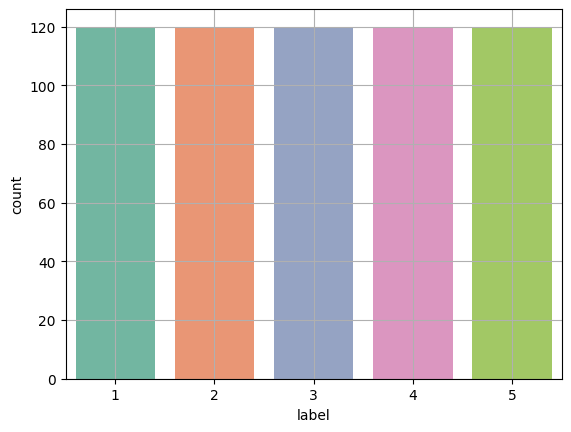

In [114]:
sns.countplot(x='label', data = combined_df, palette='Set2')
plt.grid()
plt.show()

* label 에 대한 정수 인코딩
    * 정수 인코딩은 0 부터 시작해야 함.

In [115]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
combined_df['label'] = le.fit_transform(combined_df['label'])
combined_df.head()

,text,label
0,심한 호흡곤란과 함께 가슴 통증이 지속되고 있는 환자,0
1,긴급 수술이 필요한 큰 출혈으로 혈액이 과도하게 유출되고 있는 환자,0
2,급성 심근경색으로 인한 심지혈관 폐색으로 심부전의 증상을 보이고 있는 환자,0
3,중증적인 두경부 손상으로 혈액이 많이 흐르고 출혈이 멈추지 않는 환자,0
4,신체의 일부분이 갑작스럽게 마비되어 움직일 수 없는 환자,0


### (4) GPU 설정
* 파이토치를 위한 설정

In [116]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 2.데이터 준비

### (1) Dataset 만들기 : train, val

In [117]:
# 데이터셋 분할
train, val = train_test_split(combined_df, test_size=0.2, random_state=42)

In [118]:
# 텐서 데이터셋으로 변환
train_ds = Dataset.from_pandas(train)
val_ds = Dataset.from_pandas(val)

In [119]:
train_ds[:3]

{'text': ['급성 심근경색으로 심장부위가 아프고 호흡이 어려워지면 수술로 급히 처치되어야 합니다.',
  '화재로부터 발생한 중증화상을 입은 환자',
  '흉통과 혈전증상을 겪는 청년 남성'],
 'label': [1, 0, 3],
 '__index_level_0__': [145, 9, 375]}

### (2) 토큰화

* 사용할 모델("klue/bert-base")의 토크나이저를 저장

In [175]:
# 모델과 토크나이저 불러오기
model_name = "klue/bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [176]:
# 토큰화 함수 생성 및 적용
def preprocess_function(data):
    return tokenizer(data['text'], truncation=True, padding=True)

train_ds = train_ds.map(preprocess_function, batched=True)
val_ds = val_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

## 3.Fine-Tuning

### (1) 사전학습 모델 준비
* 사용할 모델("klue/bert-base")의 토크나이저를 저장
* 이때, 출력층 노드 수를 지정합니다.

In [177]:
# 모델 설정 (다중 분류를 위해 num_labels 지정)
n = 6
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = n).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### (2) 학습
* 절차
    * TrainArguments 설정
        * 조정할 하이퍼파라미터 : learning_rate, batch_size, epochs, weight_decay 등
        * 나머지 옵션은 손 대지 맙시다.
    * Trainer 설정
    * 학습
* 성능 : 데이터, 하이퍼파라미터에 의해 결정

In [201]:
# TrainingArguments

lr = 2e-5           # <--
batch_size = 32        # <--
epochs = 30            # <--

training_args = TrainingArguments(
    output_dir = './results',          # 출력 디렉토리
    eval_strategy = "epoch",            # 에폭마다 평가
    save_strategy = "epoch",           # 에폭마다 체크포인트 저장
    learning_rate = lr,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs  = epochs,
    weight_decay = 0.01,               # <--[조정가능]weight decay
    load_best_model_at_end = True,     # 가장 좋은 모델을 마지막에 로드
    logging_dir ='./logs',            # 로깅 디렉토리
    logging_steps = 10,                # 로깅 스텝
    report_to="tensorboard"          # TensorBoard에 로깅
)

In [202]:
# Trainer 설정
patience = 5       # <--

trainer = Trainer(
    model=model,                         # 학습할 모델
    args=training_args,                  # TrainingArguments
    train_dataset = train_ds,
    eval_dataset = val_ds,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=patience)], # 조기 종료
)

In [203]:
# 모델 학습
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.000900,0.956306
2,0.010600,0.990680
3,0.002100,0.931108
4,0.000500,0.869833
5,0.008700,0.841062
6,0.001300,0.784548
7,0.007400,0.915730
8,0.010700,0.927843
9,0.020800,0.844946
10,0.029400,0.839530


TrainOutput(global_step=255, training_loss=0.00520511761823596, metrics={'train_runtime': 633.7835, 'train_samples_per_second': 22.721, 'train_steps_per_second': 0.71, 'total_flos': 134191457464320.0, 'train_loss': 0.00520511761823596, 'epoch': 17.0})

In [204]:
# 모델 평가
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Evaluation results: {'eval_loss': 0.6780802607536316, 'eval_runtime': 0.2688, 'eval_samples_per_second': 446.368, 'eval_steps_per_second': 14.879, 'epoch': 17.0}


### (3) 모델 검증평가
* evaluate 함수를 이용해서 검증셋에 대한 성능 평가를 수행합니다.

In [205]:
pred, prob = evaluate(val_ds, model, device, tokenizer)

In [206]:
print(confusion_matrix(val_ds['label'], pred))
# print(classification_report(val_ds['label'], pred, target_names = le.classes_)) :: target_names 변환은 label이 문자 일때만 넣도록 하자.
print(classification_report(val_ds['label'], pred))

[[21  1  2  1  0]
 [ 0 21  3  1  0]
 [ 2  1 18  0  3]
 [ 1  0  0 20  0]
 [ 1  1  0  0 23]]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        25
           1       0.88      0.84      0.86        25
           2       0.78      0.75      0.77        24
           3       0.91      0.95      0.93        21
           4       0.88      0.92      0.90        25

    accuracy                           0.86       120
   macro avg       0.86      0.86      0.86       120
weighted avg       0.86      0.86      0.86       120



### (4) 모델 사용
* 응급상황에 대한 샘플 문자을 넣고 등급을 적절히 분류하는지 눈으로 확인해 봅시다.

In [216]:
text = "사람"
predicted_class, probabilities = predict(text, model, tokenizer)

print(f"예측된 클래스: {predicted_class}")
print(f"예측된 클래스 이름: {le.inverse_transform([predicted_class])}")
print(f"클래스별 확률: {probabilities}")

예측된 클래스: 4
예측된 클래스 이름: [5]
클래스별 확률: tensor([[0.0034, 0.0017, 0.0454, 0.0037, 0.9445, 0.0013]], device='cuda:0')


## 4.모델 저장

### (1) 모델 저장
* save_pretrained 메서드를 사용해 모델과 토크나이저를 디렉토리에 저장합니다.
* 저장 대상 : 모델, 토크나이저

In [149]:
# 모델과 토크나이저 저장 경로 : 폴더가 없으면, fine_tuned_bert를 생성
save_directory = path + "fine_tuned_bert"

# 모델 저장
model.save_pretrained(save_directory)

# 토크나이저도 함께 저장
tokenizer.save_pretrained(save_directory)

('/content/drive/MyDrive/project6/2/fine_tuned_bert/tokenizer_config.json',
 '/content/drive/MyDrive/project6/2/fine_tuned_bert/special_tokens_map.json',
 '/content/drive/MyDrive/project6/2/fine_tuned_bert/vocab.txt',
 '/content/drive/MyDrive/project6/2/fine_tuned_bert/added_tokens.json',
 '/content/drive/MyDrive/project6/2/fine_tuned_bert/tokenizer.json')

### (2) 모델 로딩 및 사용
* 저장한 모델을 나중에 다시 불러와 예측이나 추가 작업에 사용할 수 있습니다. Hugging Face from_pretrained 메서드를 사용하여 저장 경로에서 모델과 토크나이저를 로드합니다.
* 로딩 대상 : 모델, 토크나이저

In [153]:
# 모델 로드
model2 = AutoModelForSequenceClassification.from_pretrained(save_directory).to(device)

# 토크나이저 로드
tokenizer2 = AutoTokenizer.from_pretrained(save_directory)

In [154]:
text = "넘어졌는데, 지금 출혈이 있고, 머리가 어지럽습니다."
predicted_class, probabilities = predict(text, model2, tokenizer2)

print(f"예측된 클래스: {predicted_class}")
print(f"예측된 클래스 이름: {predicted_class+1}등급")
print(f"클래스별 확률: {probabilities}")

예측된 클래스: 3
예측된 클래스 이름: 4등급
클래스별 확률: tensor([[0.0250, 0.0840, 0.0929, 0.6787, 0.1096, 0.0099]], device='cuda:0')
